In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN, Bidirectional, Conv1D, MaxPooling1D, Flatten
import pywt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

# Enable GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Find CSV files
files = glob.glob(r'D:\A_NAUSHAD\E\Dataset\Book6.csv')

def wavelet_transform(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet, mode='periodization')
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet='db1'):
    return pywt.waverec(coeffs, wavelet, mode='periodization')

# Function to evaluate predictions
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)

    return {
        "mae": mae.numpy().mean(),
        "mse": mse.numpy().mean(),
        "rmse": rmse.numpy().mean(),
        "mape": mape.numpy().mean(),
        "mslr": mslr.numpy().mean(),
    }

# Model creation functions
def create_1dcnn_model(input_shape):
    model = tf.keras.Sequential()
    tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape)
   # model.add(MaxPooling1D(pool_size=2))
    tf.keras.layers.Flatten()
    tf.keras.layers.Dense(1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model
'''
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(10, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

def create_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(10, activation='relu'), input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(10, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model
'''

# Function to save DataFrame to CSV
def save_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

# Function to process and save results
def process_and_save_results(model_name, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed):
    forecast_dates = pd.date_range(start='2023-01-28', end='2024-12-31', freq='H')
    df_forecast = pd.DataFrame(index=forecast_dates)
    
    feature_scaled = feature_transformed.reshape(-1, 1)
    scaler = MinMaxScaler()
    feature_scaled = scaler.fit_transform(feature_scaled)

    forecast_generator = TimeseriesGenerator(feature_scaled, np.zeros(len(feature_scaled)), length=len(X_train), sampling_rate=1, batch_size=1)
    predicted_values_forecast = model.predict(forecast_generator)
    predicted_values_forecast = scaler.inverse_transform(predicted_values_forecast)

    if len(predicted_values_forecast) > len(df_forecast):
        predicted_values_forecast = predicted_values_forecast[:len(df_forecast)]
    else:
        forecast_values = np.full((len(df_forecast), 1), np.nan)
        forecast_values[:len(predicted_values_forecast)] = predicted_values_forecast
        predicted_values_forecast = forecast_values

    df_forecast[column] = predicted_values_forecast
    df_forecast.to_csv(f'D:/A_NAUSHAD/E/RESULTS/FORE/{model_name}_{column}_Wave_fore.csv')

    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast[column], label='Forecasted')
    plt.xlabel('Hour')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Forecast of Hourly {column} concentration using {model_name}')
    plt.show()
    
    pd.DataFrame(history.history['loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/{model_name}_{column}_Wave_loss.csv')
    pd.DataFrame(history.history['val_loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/{model_name}_{column}_Wave_val_loss.csv')

    predictions_train = model.predict(X_train)
    pd.DataFrame(predictions_train).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/{model_name}_{column}_Wave_train_pred.csv')
    predictions_test = model.predict(X_test)
    pd.DataFrame(predictions_test).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/{model_name}_{column}_Wave_test_pred.csv')

    eval_results = evaluate_preds(y_true=y_test_inverse, y_pred=y_pred_inverse)
    eval_df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['value'])
    eval_df.to_csv(f'D:/A_NAUSHAD/E/RESULTS/EVAL/{model_name}_{column}_Wave_eval.csv')

# Dictionary of models
models = {
    "1DCNN": create_1dcnn_model,
#     "LSTM": create_lstm_model,
#     "GRU": create_gru_model,
#     "BiLSTM": create_bilstm_model,
#     "RNN": create_rnn_model
}

# Loop over files and models
for file in files:
    df = pd.read_csv(file, parse_dates=['Date'], index_col=['Date'])

    # Create a ThreadPoolExecutor for parallel file operations
    with ThreadPoolExecutor(max_workers=4) as executor:
        # List of tasks to execute
        tasks = []

        for column in df.columns:
            feature = df[[column]].values
            target = df[[column]].values

            feature_wavelet = wavelet_transform(feature)
            target_wavelet = wavelet_transform(target)

            feature_transformed = feature_wavelet[0]
            target_transformed = target_wavelet[0]

            X_train, X_test, y_train, y_test = train_test_split(feature_transformed, target_transformed, test_size=0.15, random_state=1, shuffle=False)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)

            X_train = np.expand_dims(X_train, axis=-1)
            X_val = np.expand_dims(X_val, axis=-1)
            X_test = np.expand_dims(X_test, axis=-1)
            
            for model_name, create_model in models.items():
                model = create_model((X_train.shape[1], X_train.shape[2]))
                
                lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, cooldown=1)
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
                
                history = model.fit(
                    X_train, y_train, 
                    epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size=128,
                    callbacks=[lr_monitor, early_stopping],
                    verbose=2
                )
                
                loss = model.evaluate(X_test)
                print(f'Test loss for column {column} using {model_name}: {loss}')
                
                y_pred = model.predict(X_test)
                
                y_test_wavelet = list(target_wavelet)
                y_test_wavelet[0] = y_test
                y_pred_wavelet = list(target_wavelet)
                y_pred_wavelet[0] = y_pred.flatten()

                y_test_inverse = inverse_wavelet_transform(y_test_wavelet)
                y_pred_inverse = inverse_wavelet_transform(y_pred_wavelet)

                tasks.append(executor.submit(process_and_save_results, model_name, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed))

        for task in tasks:
            task.result()


C:\Users\rtvip\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




Epoch 1/100

184/184 - 1s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0100 - 1s/epoch - 6ms/step
Epoch 2/100
184/184 - 0s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0100 - 461ms/epoch - 3ms/step
Epoch 3/100
184/184 - 0s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0100 - 434ms/epoch - 2ms/step
Epoch 4/100
184/184 - 0s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0050 - 316ms/epoch - 2ms/step
Epoch 5/100
184/184 - 0s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0050 - 391ms/epoch - 2ms/step
Epoch 6/100
184/184 - 0s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0025 - 257ms/epoch - 1ms/step
153/153 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Test loss for column Karachi_PM2.5 using 1DCNN: 0.0
153/153 [==============================] - 0s 1ms/step
Epoch 1/100
 262/9024 [..............................] - ETA: 26s184/184 - 1s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0100 - 846ms/epoch - 5ms/step
Epoch 2/100
 710/9024 [=>......

ValueError: Found array with dim 3. None expected <= 2.

Epoch 1/100
184/184 - 1s - loss: 46.5488 - val_loss: 0.0502 - lr: 0.0100 - 1s/epoch - 8ms/step
Epoch 2/100
184/184 - 1s - loss: 0.0262 - val_loss: 0.0131 - lr: 0.0100 - 595ms/epoch - 3ms/step
Epoch 3/100
184/184 - 1s - loss: 0.0056 - val_loss: 0.0019 - lr: 0.0100 - 538ms/epoch - 3ms/step
Epoch 4/100
184/184 - 1s - loss: 7.3363e-04 - val_loss: 1.9112e-04 - lr: 0.0100 - 550ms/epoch - 3ms/step
Epoch 5/100
184/184 - 1s - loss: 5.9463e-05 - val_loss: 1.1374e-05 - lr: 0.0100 - 519ms/epoch - 3ms/step
Epoch 6/100
184/184 - 1s - loss: 2.9842e-06 - val_loss: 3.6141e-07 - lr: 0.0100 - 623ms/epoch - 3ms/step
Epoch 7/100
184/184 - 1s - loss: 1.7107e-07 - val_loss: 2.1829e-09 - lr: 0.0100 - 609ms/epoch - 3ms/step
Epoch 8/100
184/184 - 1s - loss: 8.7609e-08 - val_loss: 2.1477e-11 - lr: 0.0050 - 548ms/epoch - 3ms/step
Epoch 9/100
184/184 - 1s - loss: 8.5209e-08 - val_loss: 5.4172e-10 - lr: 0.0050 - 611ms/epoch - 3ms/step
Epoch 10/100
184/184 - 1s - loss: 8.4913e-08 - val_loss: 7.4685e-10 - lr: 0.0025 

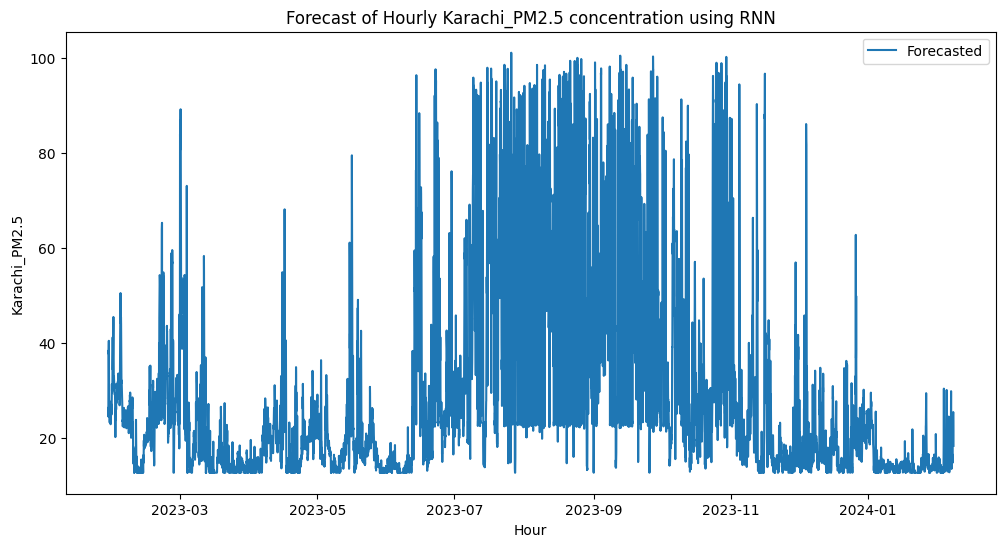

3653/9024 [===========>..................] - ETA: 1:39:24

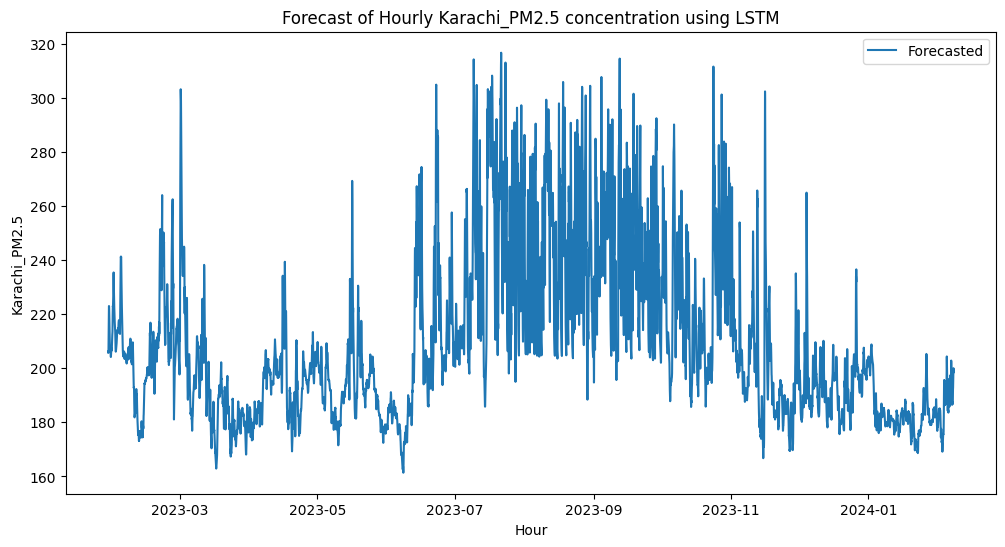

4004/9024 [============>.................] - ETA: 1:33:09

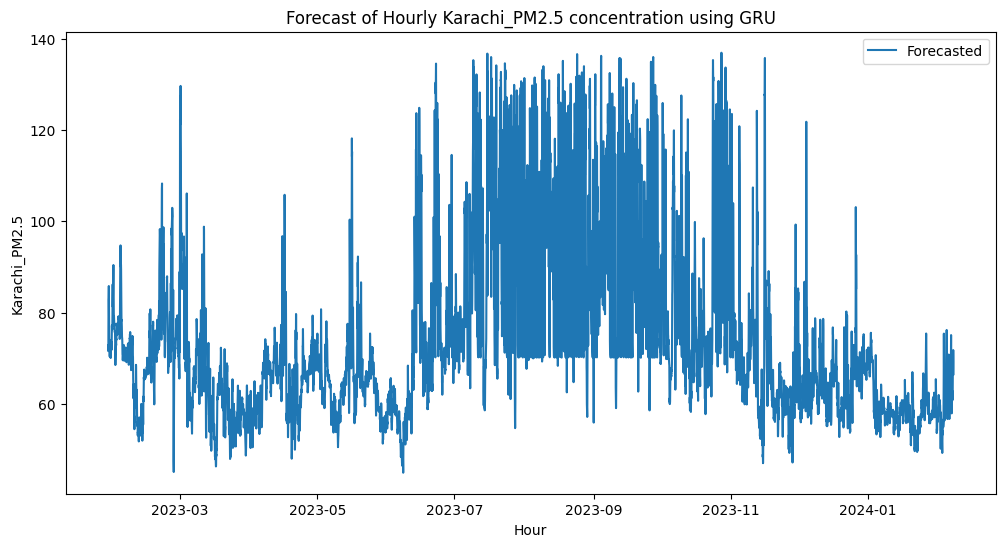

4014/9024 [============>.................] - ETA: 1:32:58

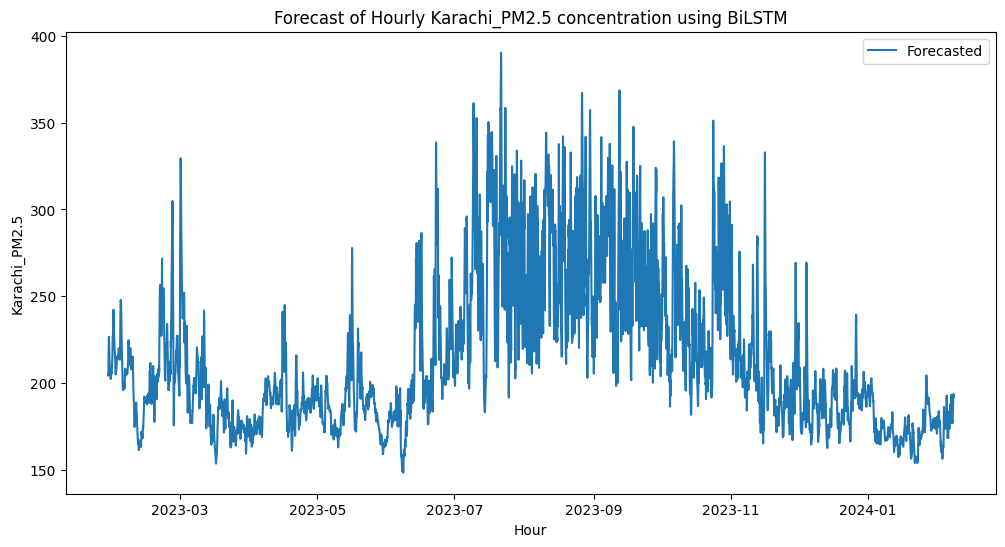

5394/9024 [================>.............] - ETA: 1:07:05

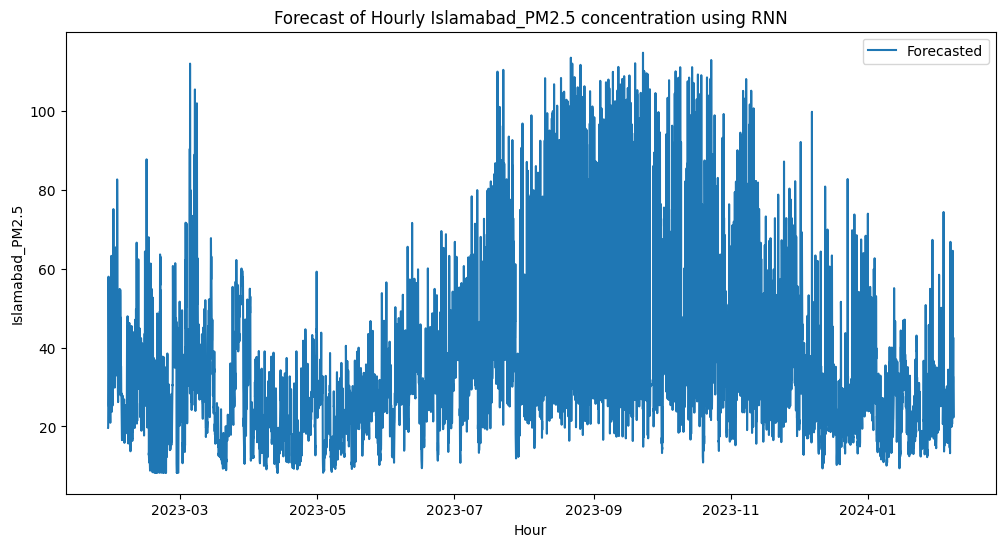

5507/9024 [=================>............] - ETA: 1:05:07

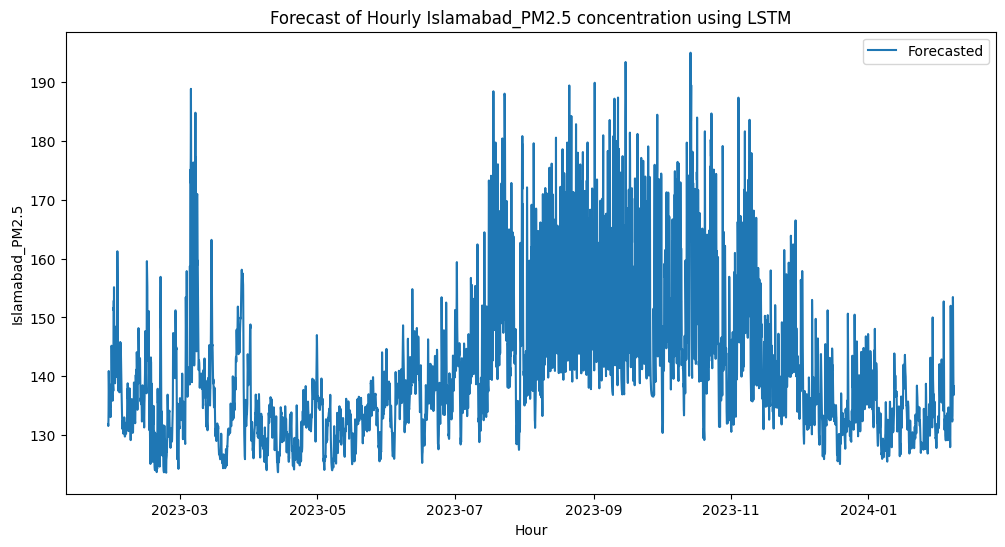

3615/9024 [===========>..................] - ETA: 1:39:58

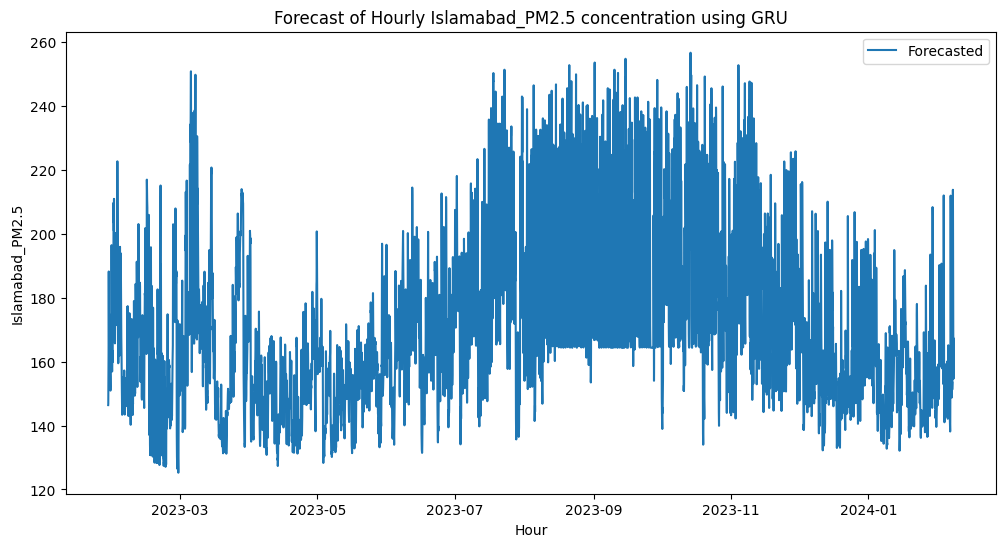

4409/9024 [=============>................] - ETA: 1:25:17

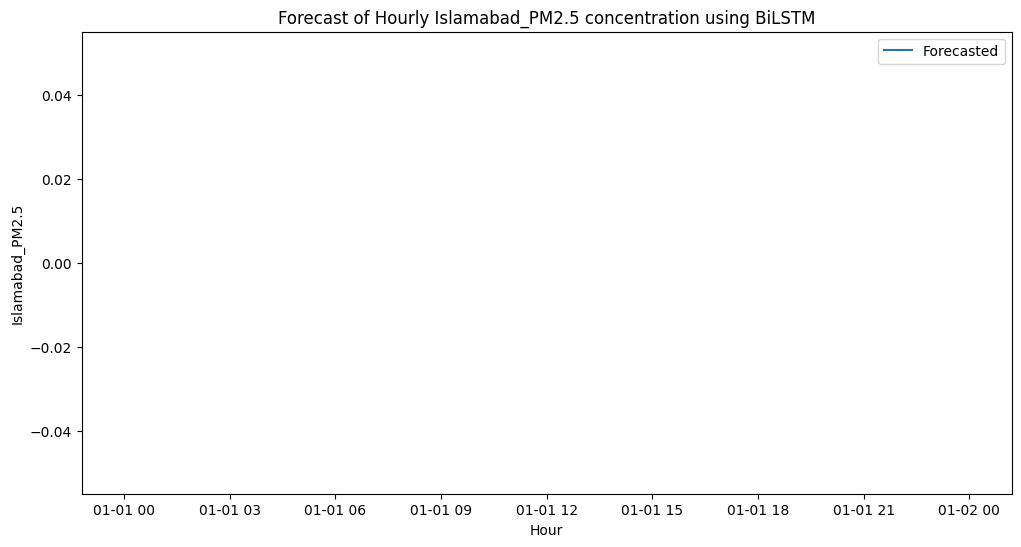

7988/9024 [=========================>....] - ETA: 12:11

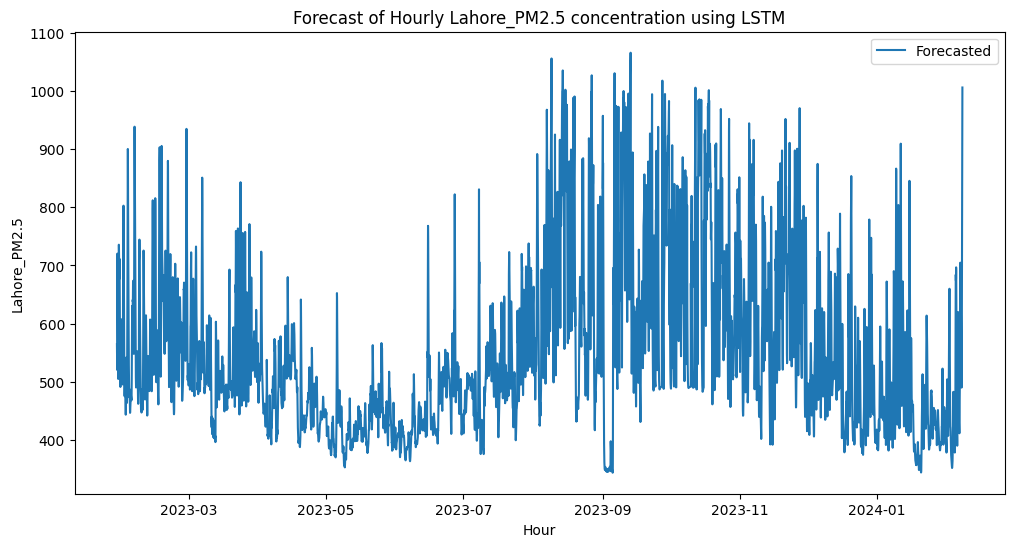

 248/9024 [..............................] - ETA: 3:39:18

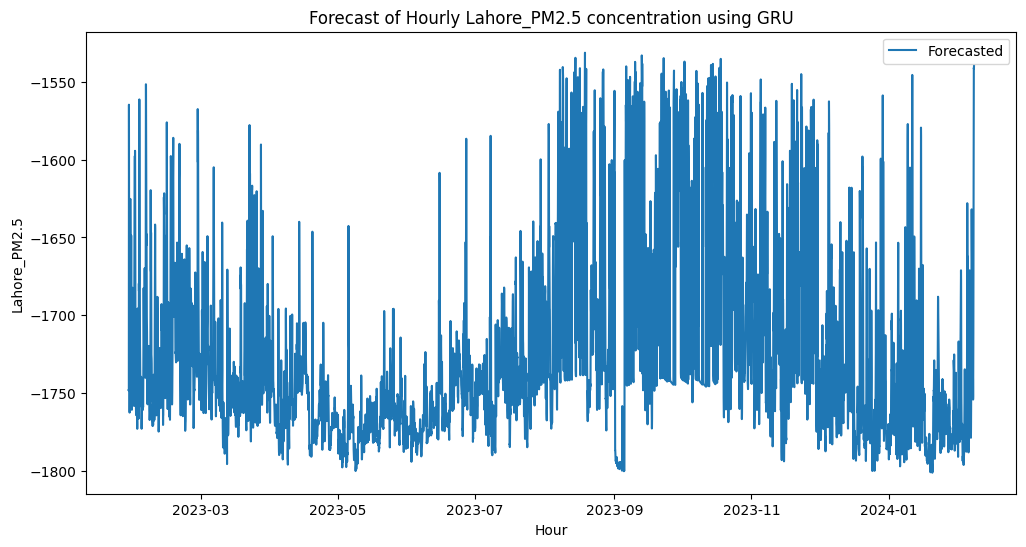

5857/9024 [==================>...........] - ETA: 1:06:23

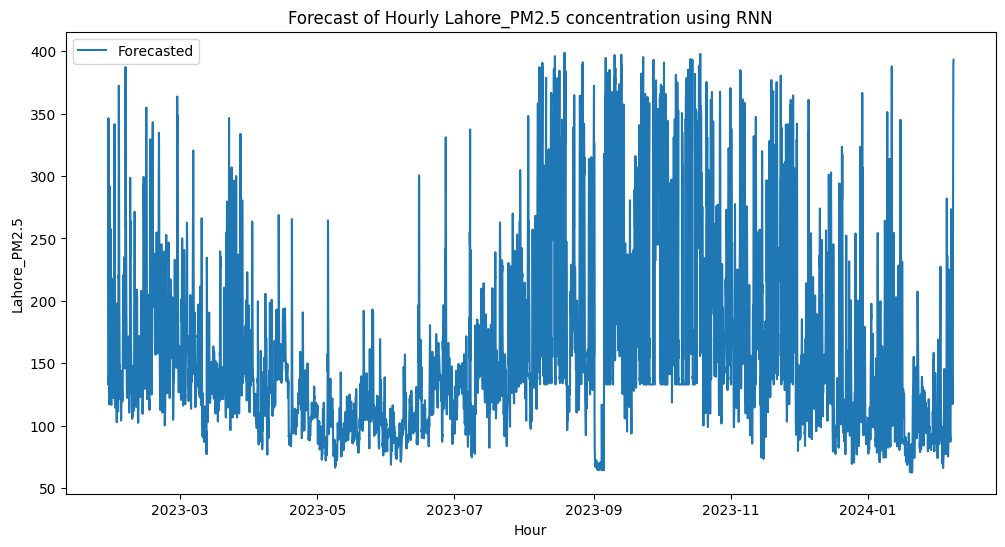

3142/9024 [=========>....................] - ETA: 2:00:14

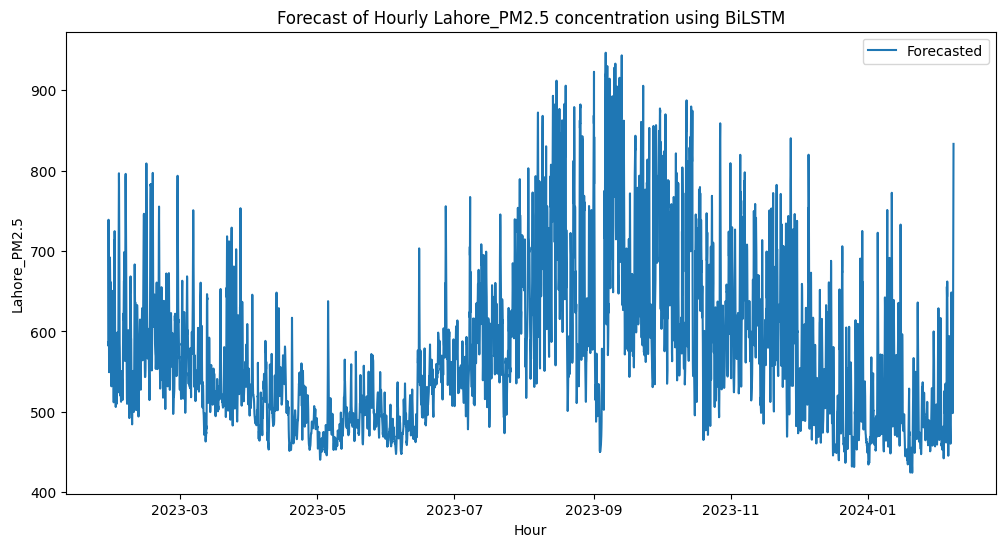

8855/9024 [============================>.] - ETA: 1:48

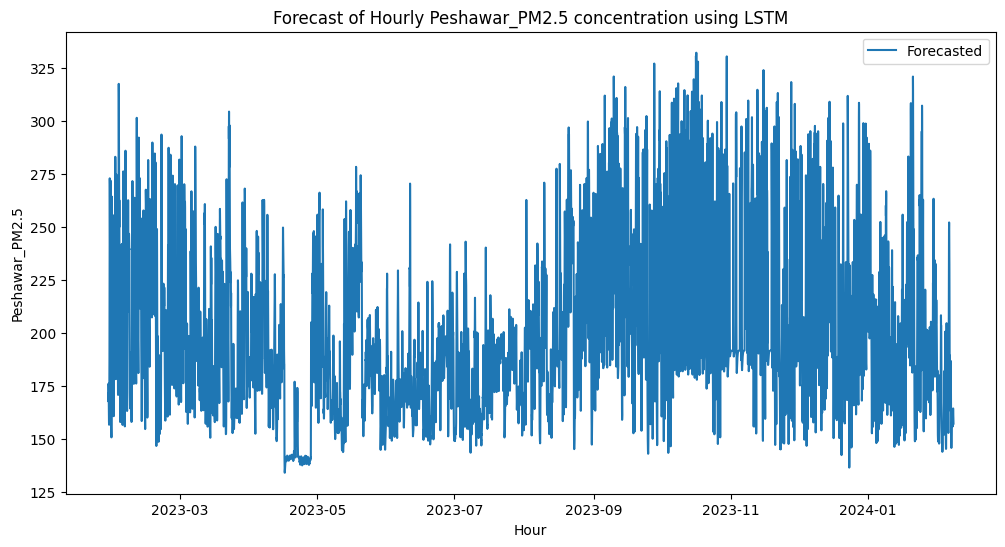

8105/9024 [=========================>....] - ETA: 18:14

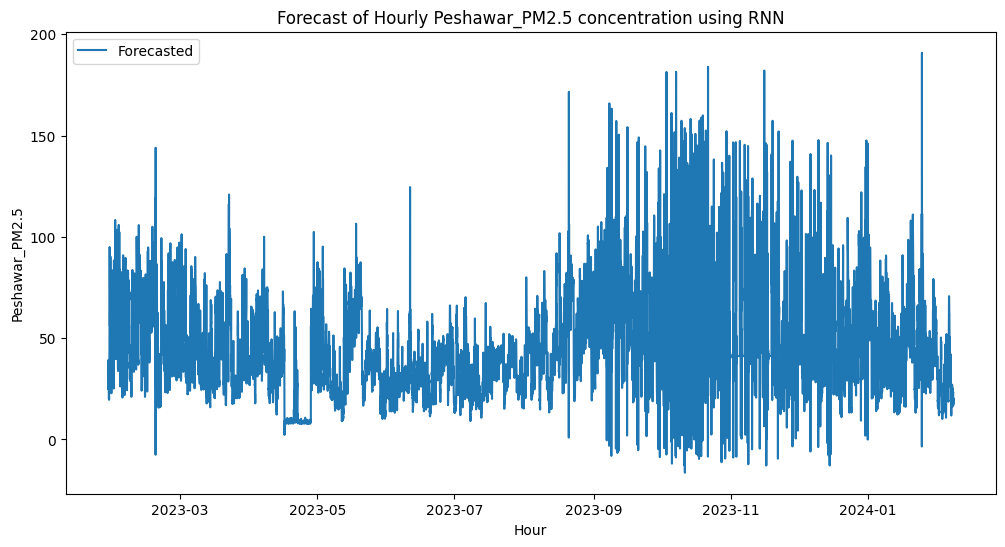

8793/9024 [============================>.] - ETA: 4:34:

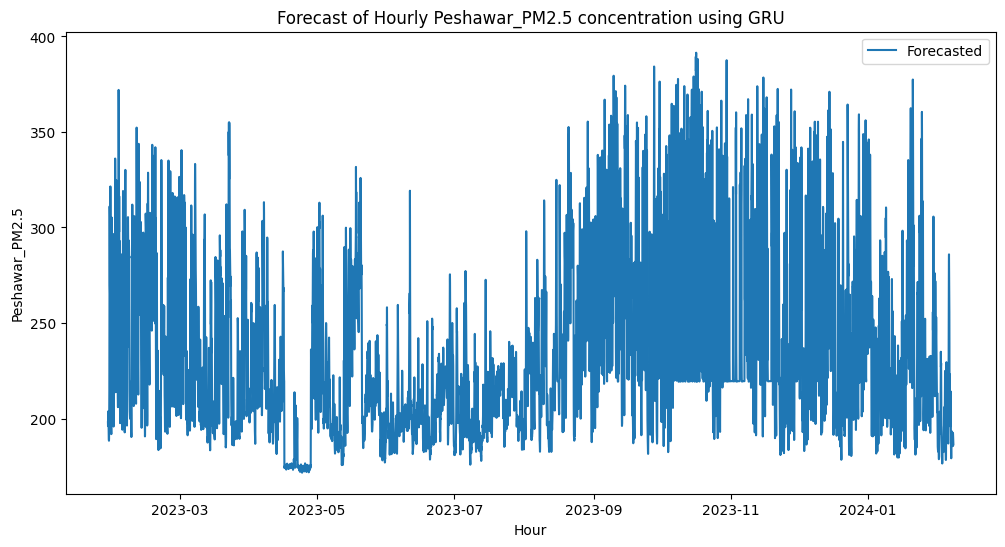

 233/9024 [..............................] - ETA: 2:48:58

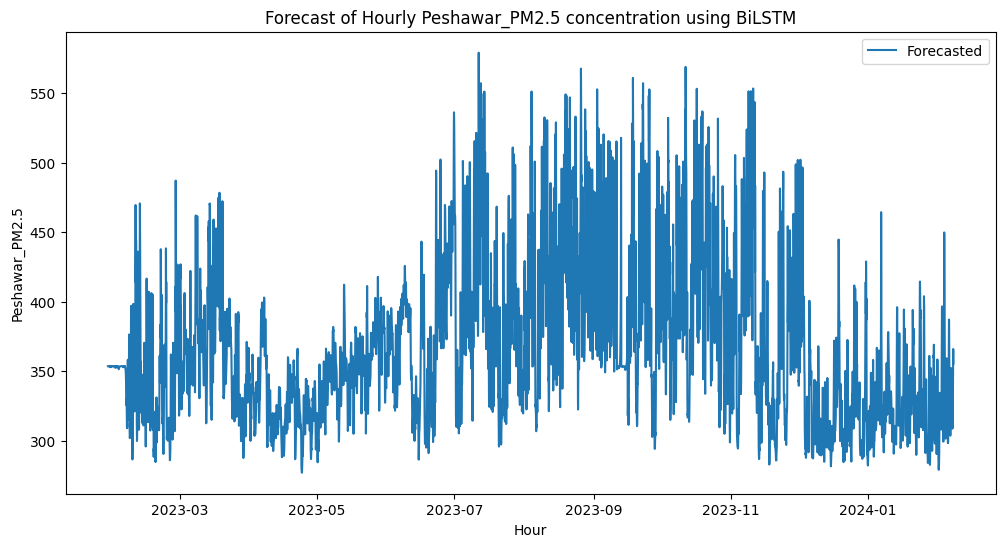

6213/9024 [===================>..........] - ETA: 55:10

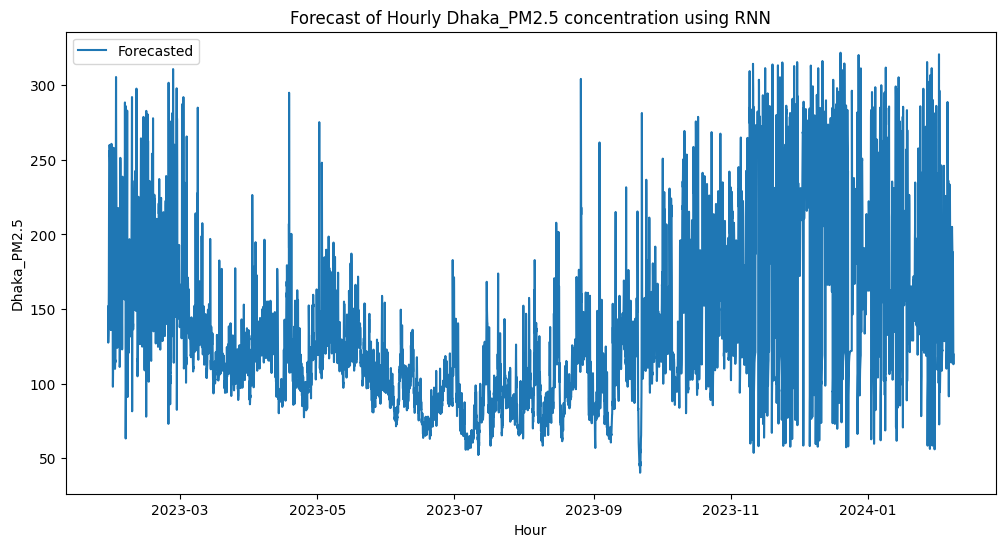

7991/9024 [=========================>....] - ETA: 20:26

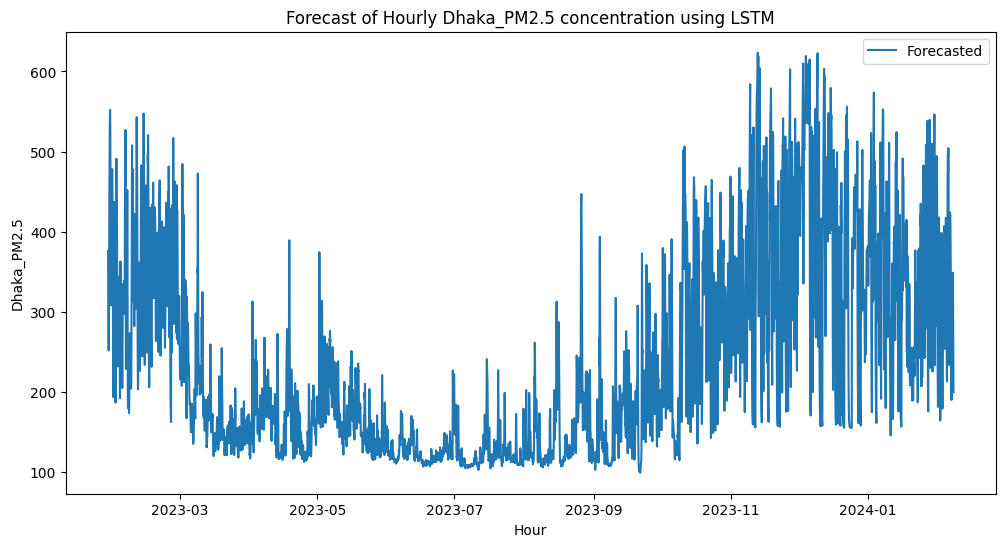

 326/9024 [>.............................] - ETA: 2:41:21

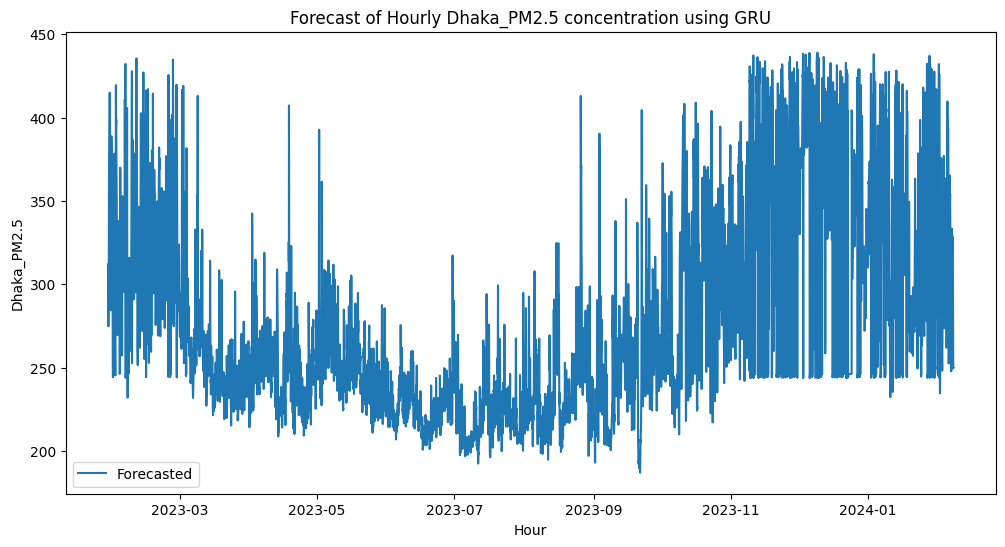

1035/9024 [==>...........................] - ETA: 2:34:07

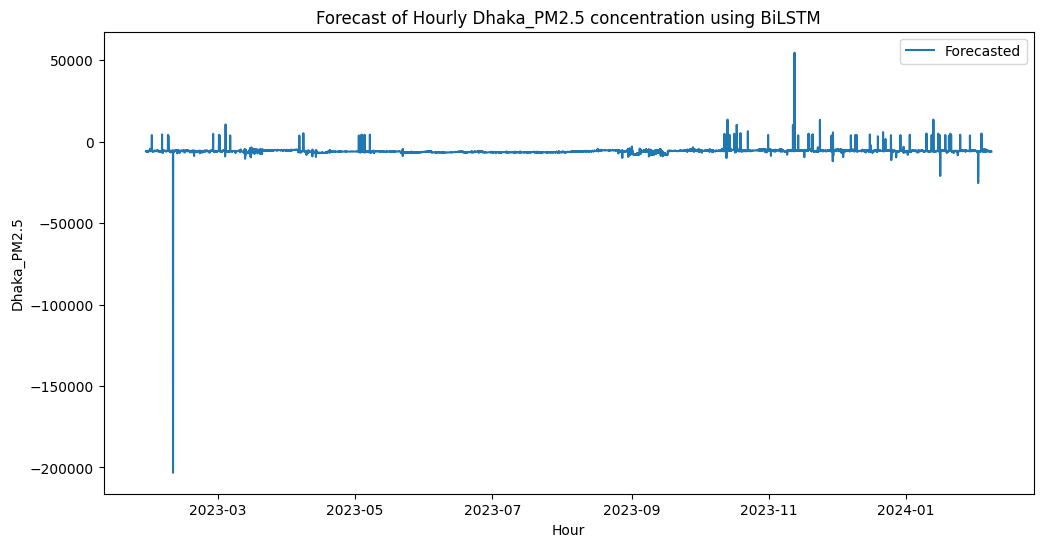

8934/9024 [============================>.] - ETA: 1:39:

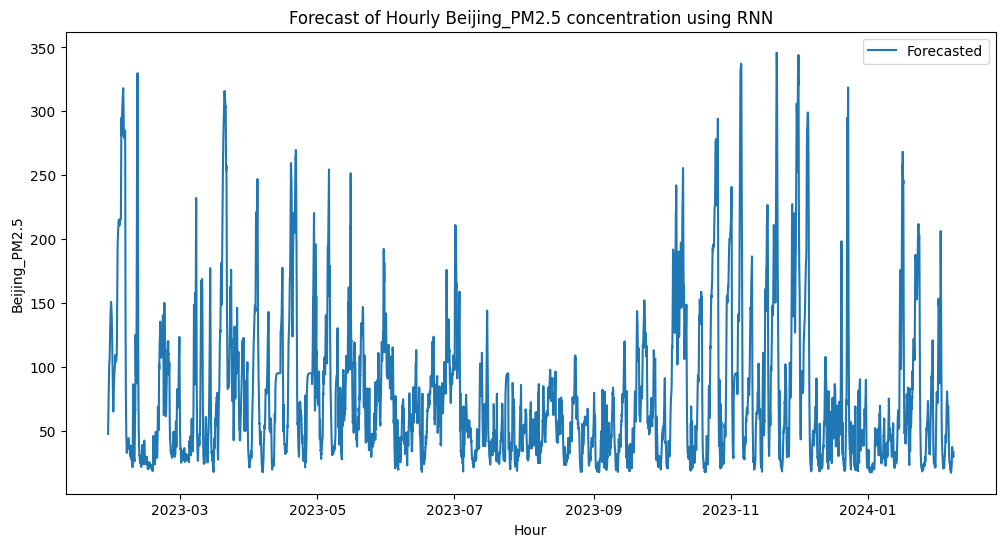

  90/9024 [..............................] - ETA: 2:43:18

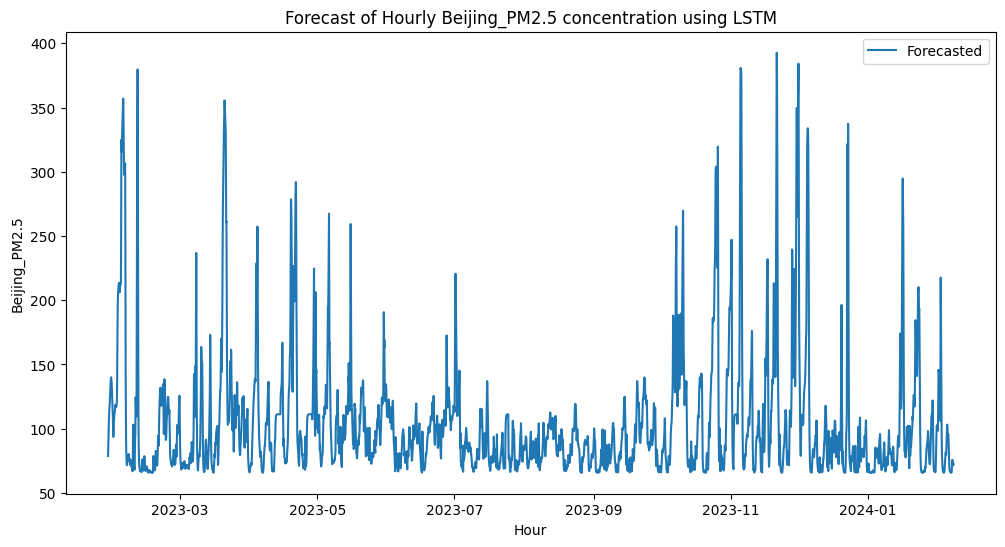

8201/9024 [==========================>...] - ETA: 16:131

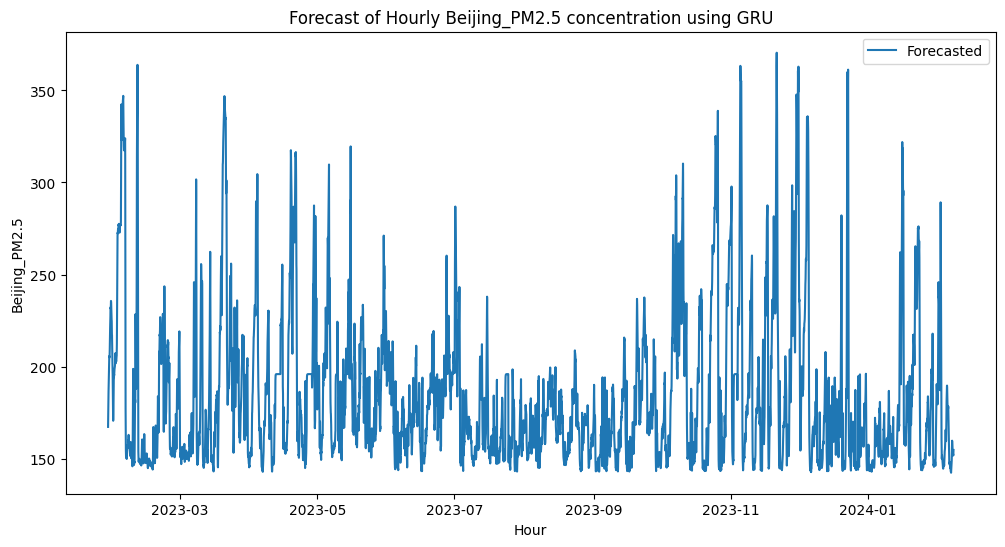

3782/9024 [===========>..................] - ETA: 1:37:49

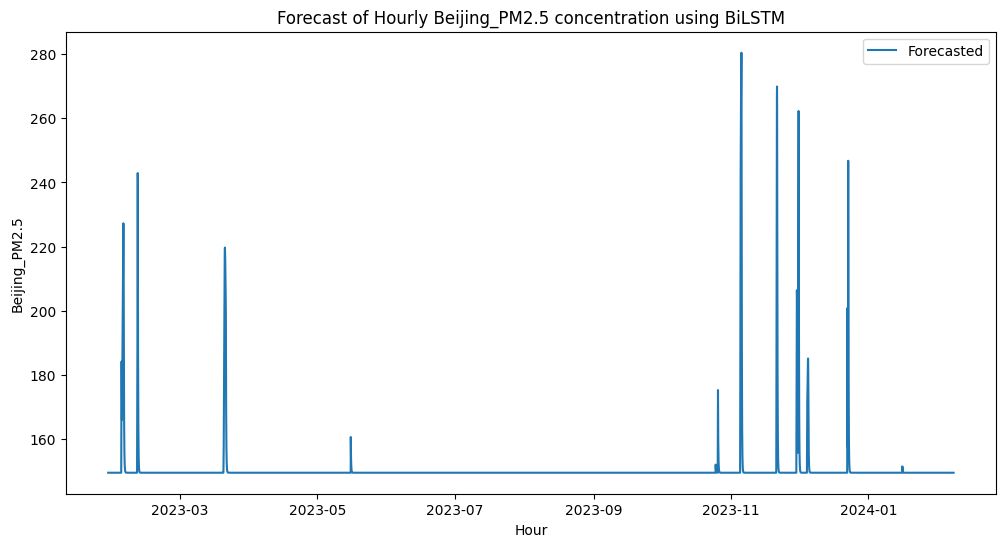

5610/9024 [=================>............] - ETA: 1:06:12

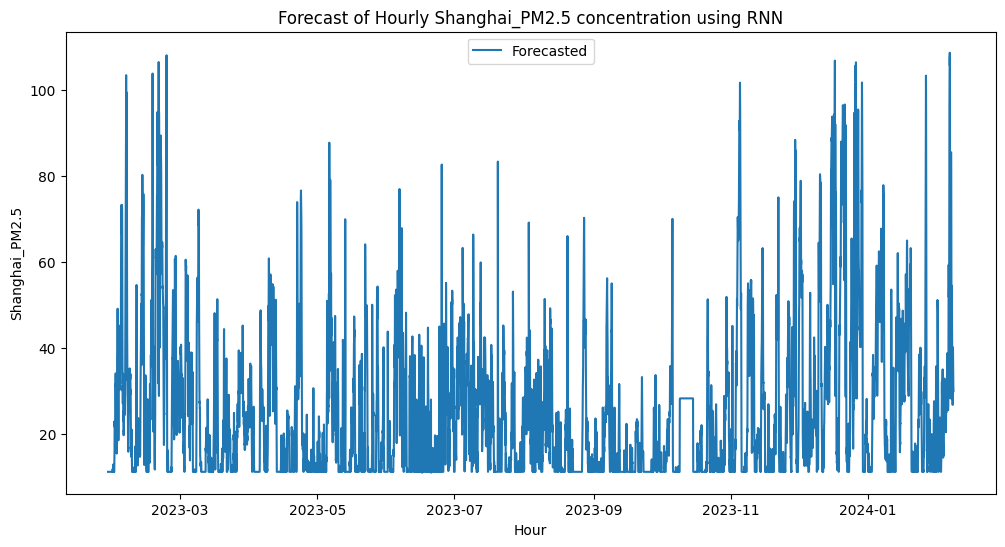

 298/9024 [..............................] - ETA: 2:41:31

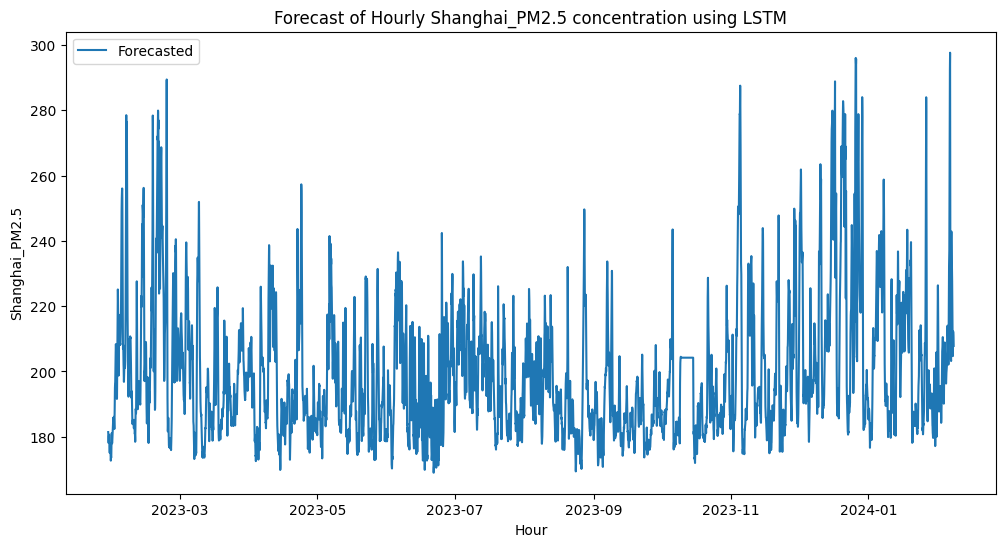

5953/9024 [==================>...........] - ETA: 59:282

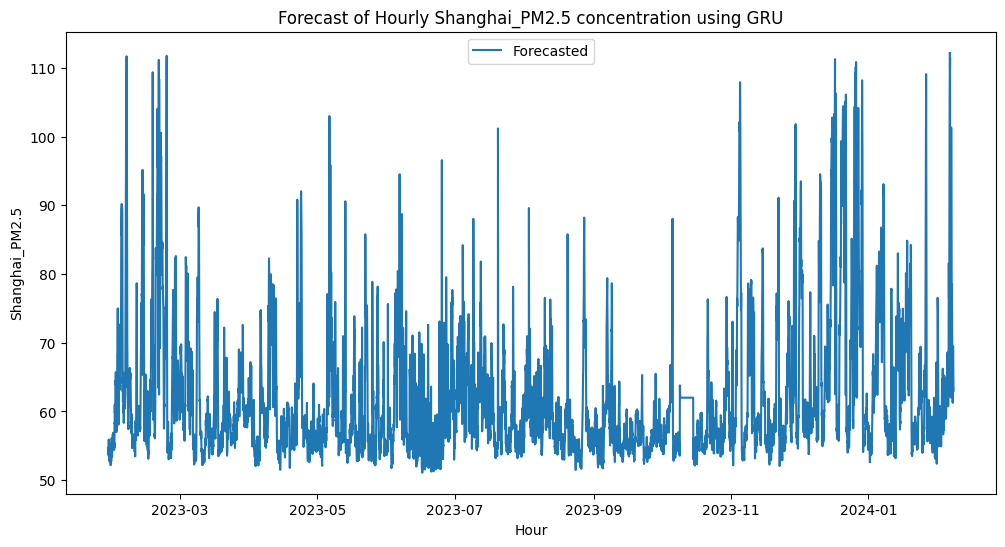

3065/9024 [=========>....................] - ETA: 1:56:36

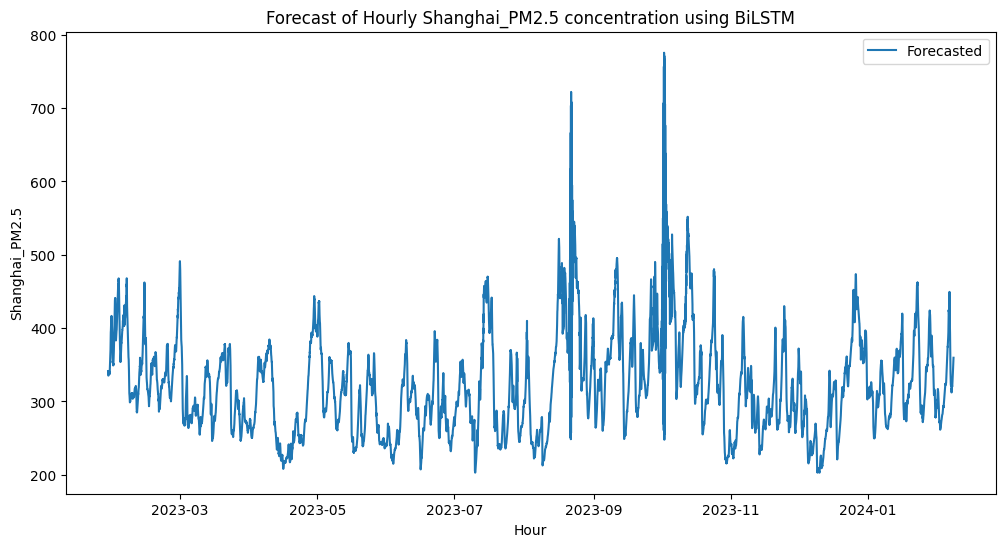

7899/9024 [=========================>....] - ETA: 21:49

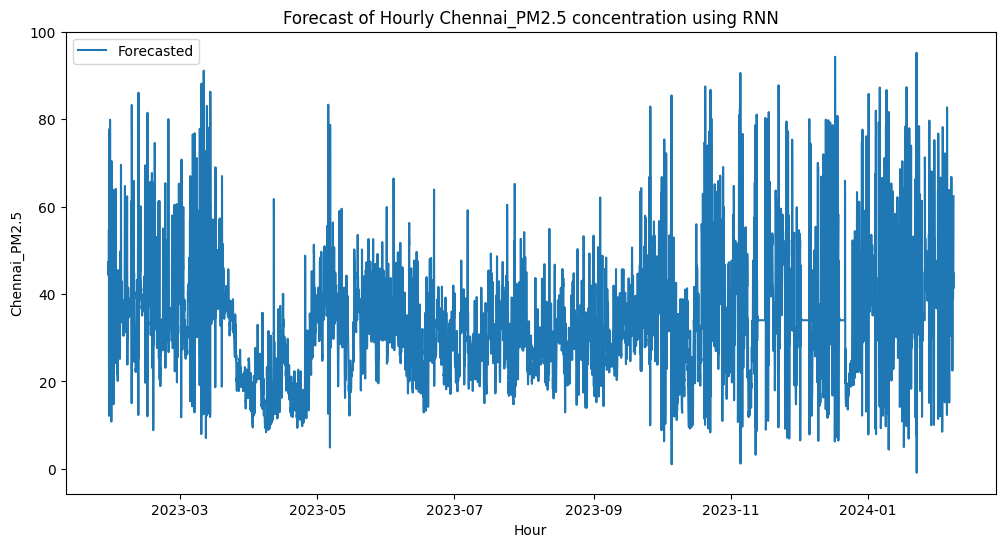

 576/9024 [>.............................] - ETA: 2:33:26

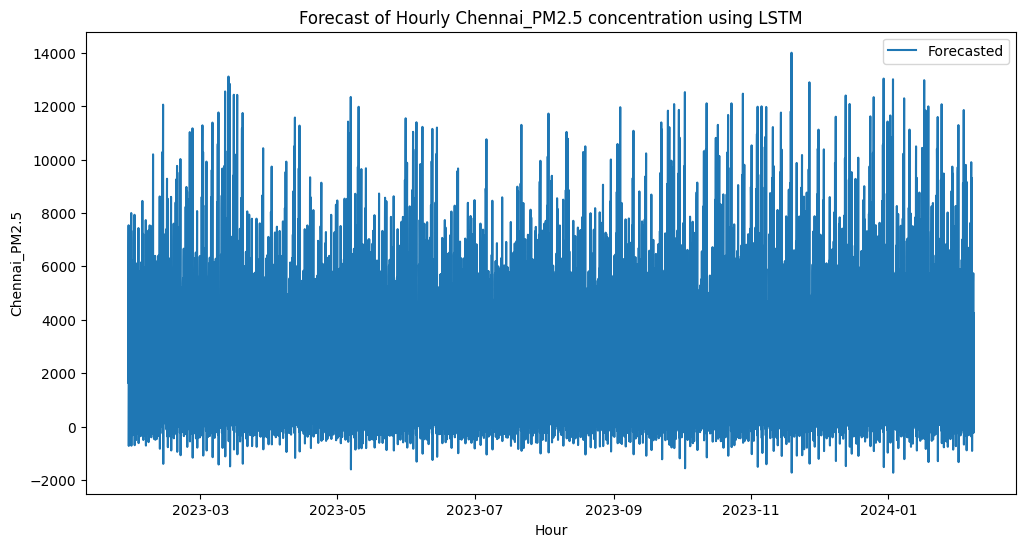

 320/9024 [>.............................] - ETA: 2:41:55

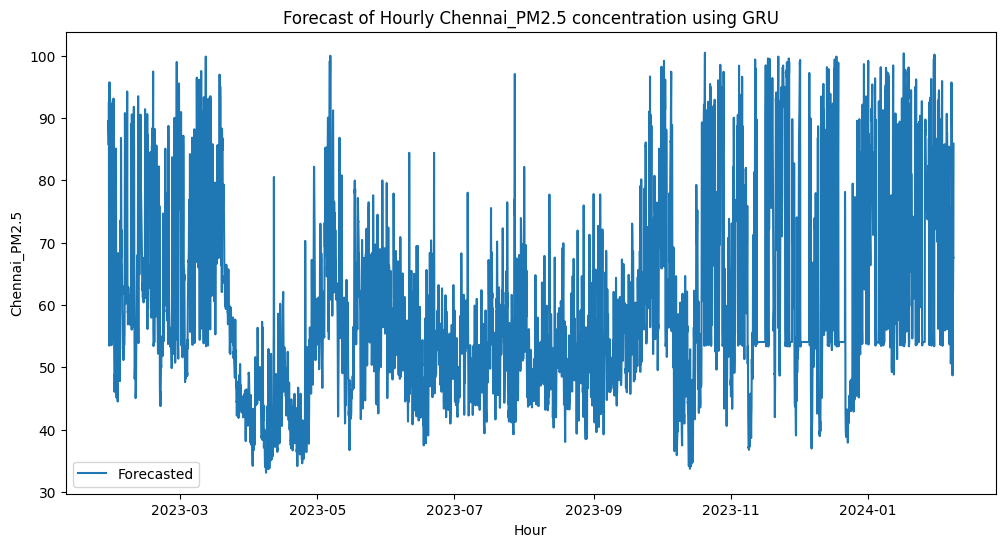

1167/9024 [==>...........................] - ETA: 2:24:34

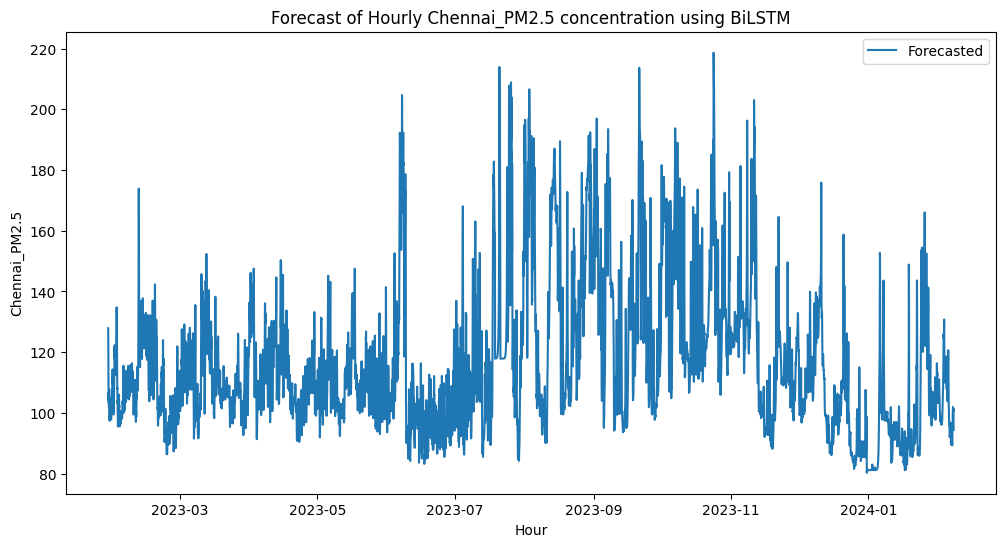

6124/9024 [===================>..........] - ETA: 54:194

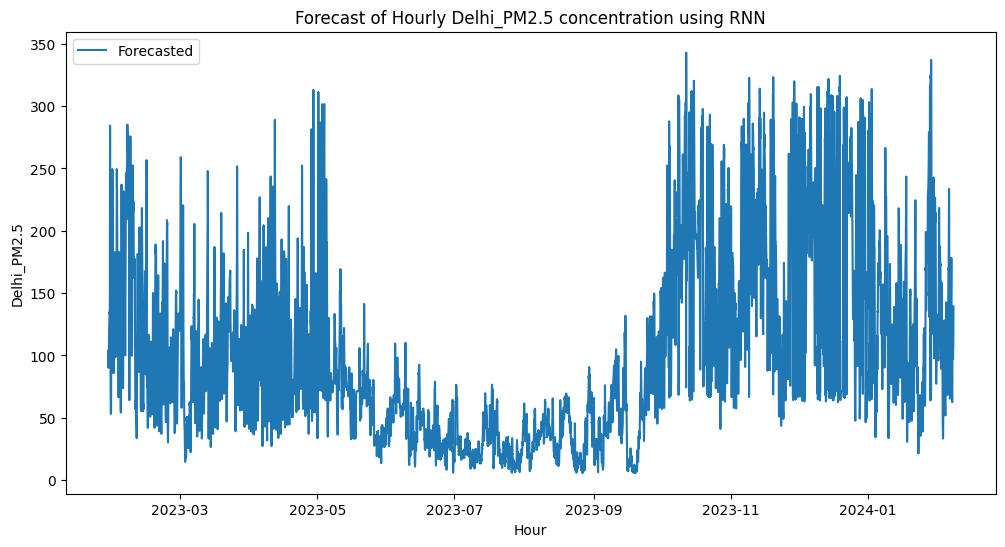

2873/9024 [========>.....................] - ETA: 1:53:16

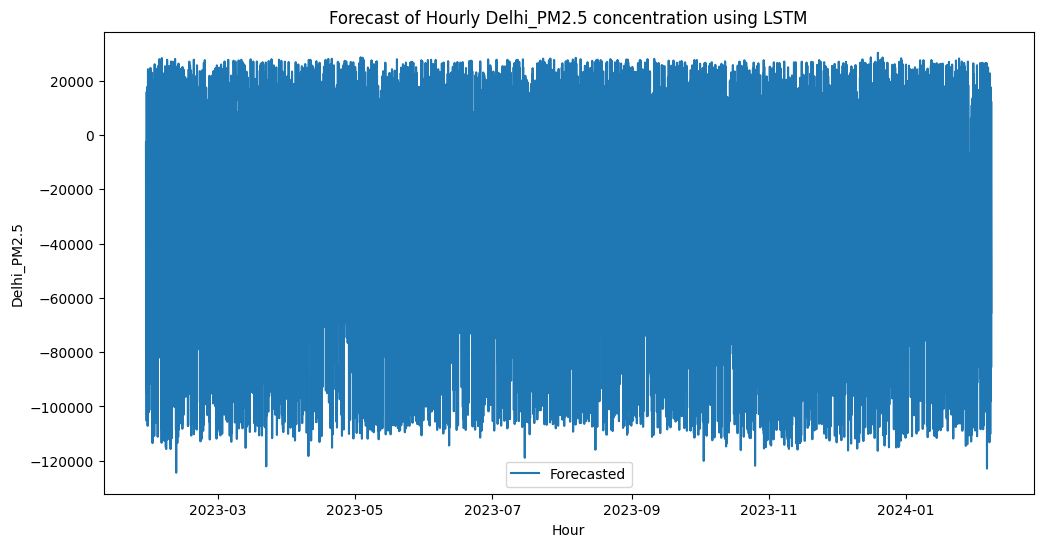

 735/9024 [=>............................] - ETA: 2:33:58

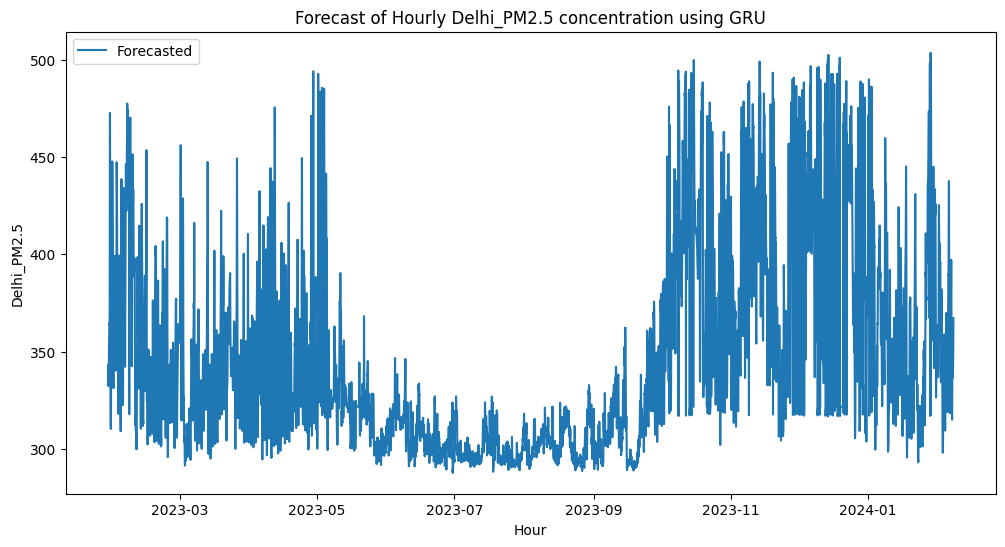

4380/9024 [=============>................] - ETA: 1:26:07

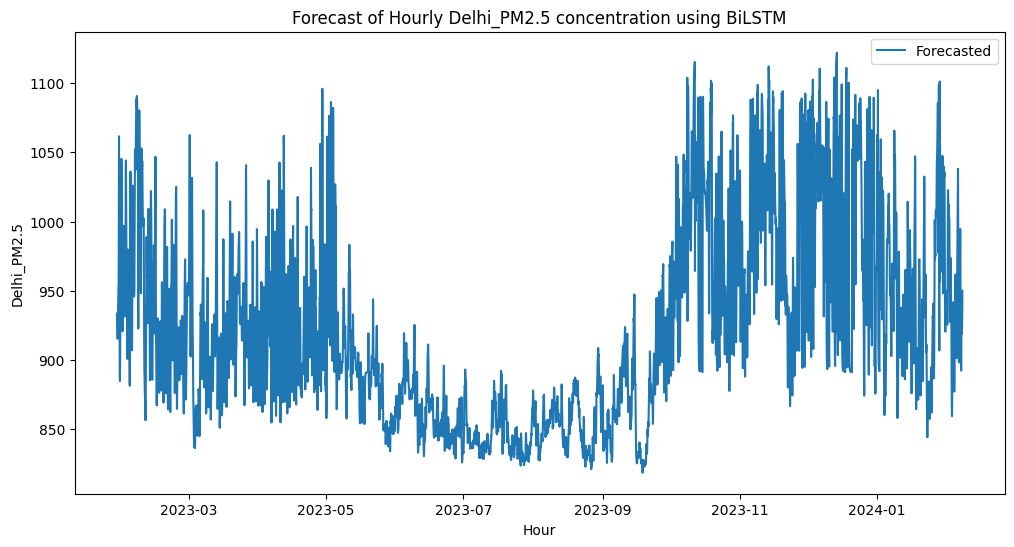

5266/9024 [================>.............] - ETA: 1:13:27

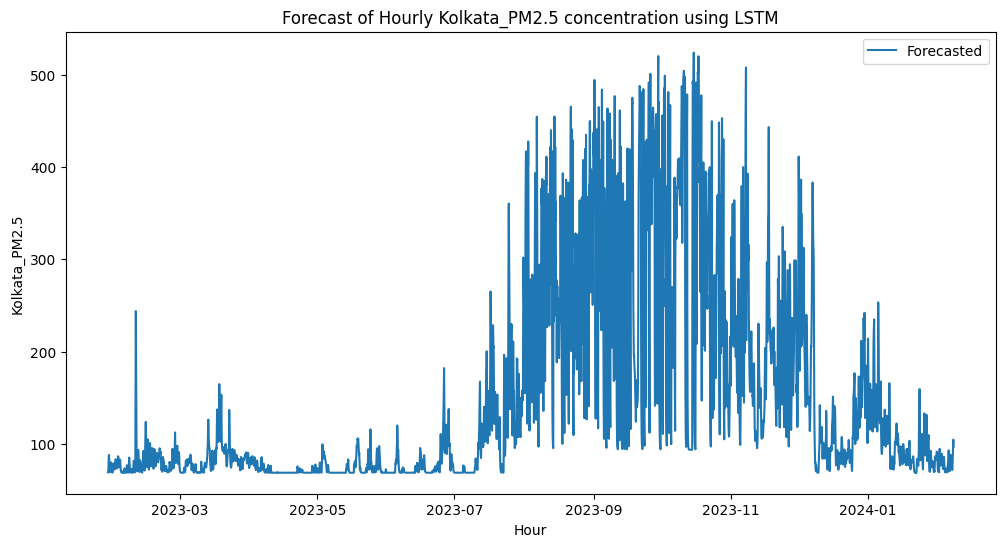

6556/9024 [====================>.........] - ETA: 46:150

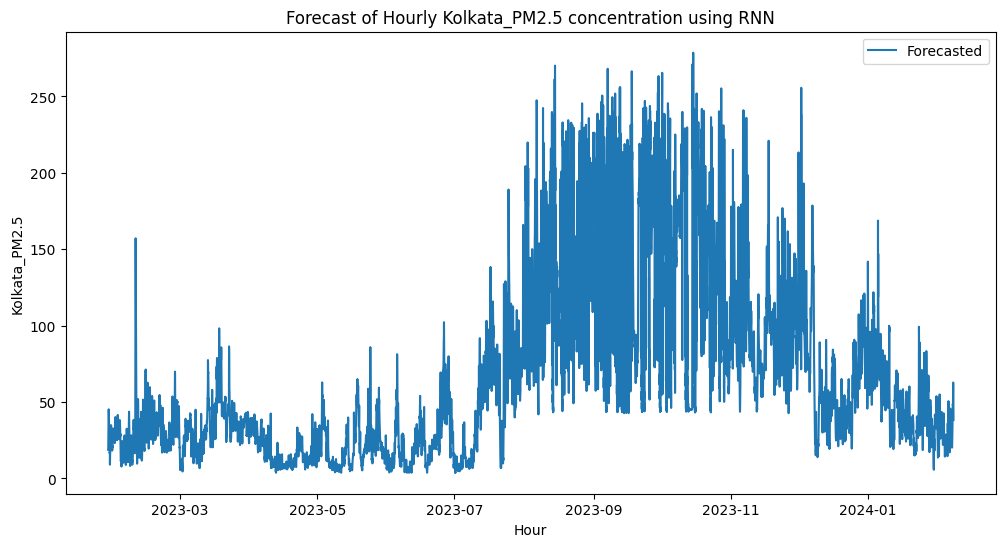

8033/9024 [=========================>....] - ETA: 19:462

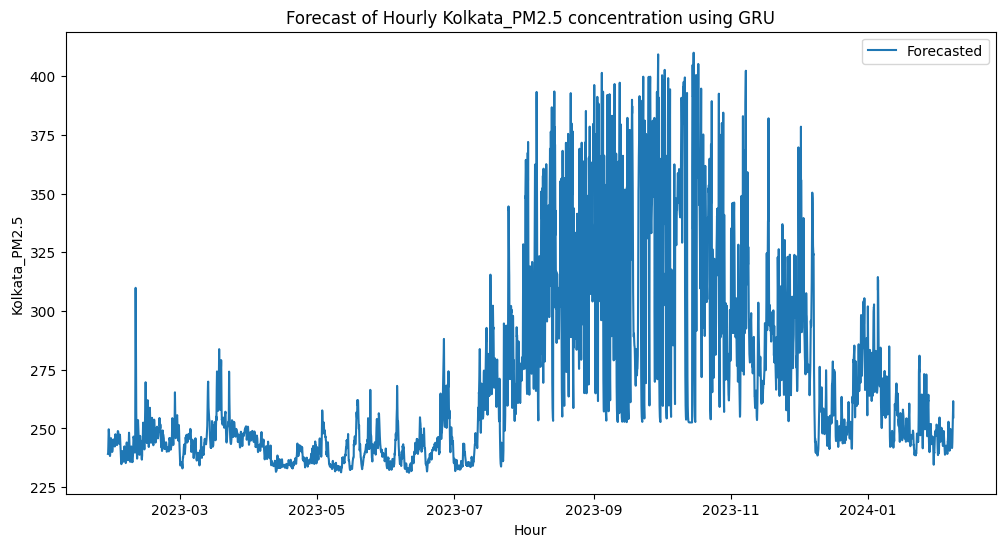

2967/9024 [========>.....................] - ETA: 2:00:05

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN, Bidirectional, Conv1D, MaxPooling1D, Flatten
import pywt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

# Enable GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Find CSV files
files = glob.glob(r'D:\A_NAUSHAD\E\Dataset\Book6.csv')

def wavelet_transform(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet, mode='periodization')
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet='db1'):
    return pywt.waverec(coeffs, wavelet, mode='periodization')

# Function to evaluate predictions
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)

    return {
        "mae": mae.numpy().mean(),
        "mse": mse.numpy().mean(),
        "rmse": rmse.numpy().mean(),
        "mape": mape.numpy().mean(),
        "mslr": mslr.numpy().mean(),
    }

# Model creation functions
def create_1dcnn_model(input_shape):
    model = Sequential()
    # Use kernel_size=1 to avoid reducing the input dimension
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    # Only add MaxPooling1D if input length is greater than 1
    if input_shape[0] > 1:
        model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(10, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

def create_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(10, activation='relu'), input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(10, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model


# Function to save DataFrame to CSV
def save_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

# Function to process and save results
def process_and_save_results(model_name, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed):
    forecast_dates = pd.date_range(start='2023-01-28', end='2025-12-31', freq='H')
    df_forecast = pd.DataFrame(index=forecast_dates)
    
    feature_scaled = feature_transformed.reshape(-1, 1)
    scaler = MinMaxScaler()
    feature_scaled = scaler.fit_transform(feature_scaled)

    forecast_generator = TimeseriesGenerator(feature_scaled, np.zeros(len(feature_scaled)), length=len(X_train), sampling_rate=1, batch_size=1)
    predicted_values_forecast = model.predict(forecast_generator)
    predicted_values_forecast = scaler.inverse_transform(predicted_values_forecast)

    if len(predicted_values_forecast) > len(df_forecast):
        predicted_values_forecast = predicted_values_forecast[:len(df_forecast)]
    else:
        forecast_values = np.full((len(df_forecast), 1), np.nan)
        forecast_values[:len(predicted_values_forecast)] = predicted_values_forecast
        predicted_values_forecast = forecast_values

    df_forecast[column] = predicted_values_forecast
    df_forecast.to_csv(f'D:/A_NAUSHAD/E/RESULTS/FORE/{model_name}_{column}_Wave_fore.csv')

    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast[column], label='Forecasted')
    plt.xlabel('Hour')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Forecast of Hourly {column} concentration using {model_name}')
    plt.show()
    
    pd.DataFrame(history.history['loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/{model_name}_{column}_Wave_loss.csv')
    pd.DataFrame(history.history['val_loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/{model_name}_{column}_Wave_val_loss.csv')

    predictions_train = model.predict(X_train)
    pd.DataFrame(predictions_train).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/{model_name}_{column}_Wave_train_pred.csv')
    predictions_test = model.predict(X_test)
    pd.DataFrame(predictions_test).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/{model_name}_{column}_Wave_test_pred.csv')

    eval_results = evaluate_preds(y_true=y_test_inverse, y_pred=y_pred_inverse)
    eval_df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['value'])
    eval_df.to_csv(f'D:/A_NAUSHAD/E/RESULTS/EVAL/{model_name}_{column}_Wave_eval.csv')

# Dictionary of models
models = {
    "1DCNN": create_1dcnn_model,
    "LSTM": create_lstm_model,
    "GRU": create_gru_model,
    "BiLSTM": create_bilstm_model,
    "RNN": create_rnn_model
}

# Loop over files and models
for file in files:
    df = pd.read_csv(file, parse_dates=['Date'], index_col=['Date'])

    # Create a ThreadPoolExecutor for parallel file operations
    with ThreadPoolExecutor(max_workers=4) as executor:
        # List of tasks to execute
        tasks = []

        for column in df.columns:
            feature = df[[column]].values
            target = df[[column]].values

            feature_wavelet = wavelet_transform(feature)
            target_wavelet = wavelet_transform(target)

            feature_transformed = feature_wavelet[0]
            target_transformed = target_wavelet[0]

            X_train, X_test, y_train, y_test = train_test_split(feature_transformed, target_transformed, test_size=0.15, random_state=1, shuffle=False)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)

            X_train = np.expand_dims(X_train, axis=-1)
            X_val = np.expand_dims(X_val, axis=-1)
            X_test = np.expand_dims(X_test, axis=-1)
            
            for model_name, create_model in models.items():
                model = create_model((X_train.shape[1], X_train.shape[2]))
                
                lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, cooldown=1)
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
                
                history = model.fit(
                    X_train, y_train, 
                    epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size=128,
                    callbacks=[lr_monitor, early_stopping],
                    verbose=2
                )
                
                loss = model.evaluate(X_test)
                print(f'Test loss for column {column} using {model_name}: {loss}')
                
#                 plt.plot(model.history["loss"],label="loss")
#                 plt.plot(model.history["val_loss"],label="val_loss")
#                 plt.legend(loc="best")
#                 plt.xlabel("No. Of Epochs")
#                 plt.ylabel("mse score")
                
                y_pred = model.predict(X_test)
                
                y_test_wavelet = list(target_wavelet)
                y_test_wavelet[0] = y_test
                y_pred_wavelet = list(target_wavelet)
                y_pred_wavelet[0] = y_pred.flatten()

                y_test_inverse = inverse_wavelet_transform(y_test_wavelet)
                y_pred_inverse = inverse_wavelet_transform(y_pred_wavelet)

                tasks.append(executor.submit(process_and_save_results, model_name, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed))

        for task in tasks:
            task.result()
